In [1]:
import torch
from gluonts.dataset.repository import get_dataset, dataset_names
from gluonts.dataset.loader import TrainDataLoader
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
import matplotlib.pyplot as plt
import numpy as np
import datasets.time_series_datasets as ts_ds

['constant', 'exchange_rate', 'solar-energy', 'electricity', 'traffic', 'exchange_rate_nips', 'electricity_nips', 'traffic_nips', 'solar_nips', 'wiki2000_nips', 'wiki-rolling_nips', 'taxi_30min', 'kaggle_web_traffic_with_missing', 'kaggle_web_traffic_without_missing', 'kaggle_web_traffic_weekly', 'm1_yearly', 'm1_quarterly', 'm1_monthly', 'nn5_daily_with_missing', 'nn5_daily_without_missing', 'nn5_weekly', 'tourism_monthly', 'tourism_quarterly', 'tourism_yearly', 'cif_2016', 'london_smart_meters_without_missing', 'wind_farms_without_missing', 'car_parts_without_missing', 'dominick', 'fred_md', 'pedestrian_counts', 'hospital', 'covid_deaths', 'kdd_cup_2018_without_missing', 'weather', 'm3_monthly', 'm3_quarterly', 'm3_yearly', 'm3_other', 'm4_hourly', 'm4_daily', 'm4_weekly', 'm4_monthly', 'm4_quarterly', 'm4_yearly', 'm5', 'uber_tlc_daily', 'uber_tlc_hourly', 'airpassengers', 'australian_electricity_demand', 'electricity_hourly', 'electricity_weekly', 'rideshare_without_missing', 'saug

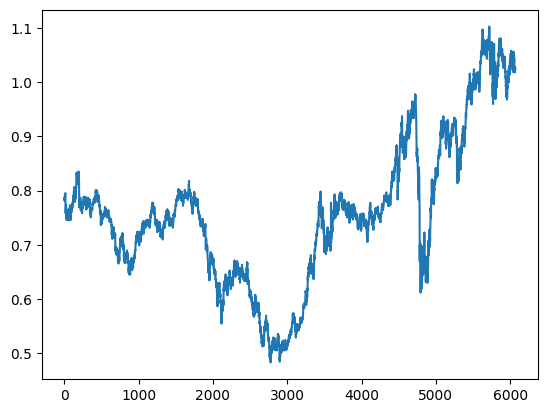

In [2]:
print(dataset_names)
dataset = get_dataset('exchange_rate')
entry = next(iter(dataset.train))
print(dataset.metadata)
print(entry.keys())
print(entry['feat_static_cat'])
data_dim = dataset.metadata.feat_static_cat[0].cardinality
target = entry['target']
print(target.shape)
plt.plot(np.arange(target.shape[0]),target)
plt.show()

In [3]:
train_dataloader, test_dataloader, metadata = ts_ds.get_transformed_dataset('electricity_nips',32,1)
i = 0
for batch in train_dataloader:
    # print(i)
    for key, value in batch.items():
        print(f'KEY ------- {key}')
        print(f'VALUE ----------- {value.shape if isinstance(value, torch.Tensor) else None}')
    
    print((batch['start']))
    print(batch['forecast_start'])
    # print(batch['past_is_pad'])
    # print(batch['past_target'].shape)
    # print(batch['future_target'].shape)
    past = batch['past_target']
    idx = torch.arange(past.shape[1]).cpu()
    # plt.plot(idx, past[i,:,0])
    # if i == 0:
    #     break
    # i+=1
    
    

KEY ------- start
VALUE ----------- None
KEY ------- feat_static_cat
VALUE ----------- torch.Size([32, 1])
KEY ------- past_target
VALUE ----------- torch.Size([32, 24, 2])
KEY ------- future_target
VALUE ----------- torch.Size([32, 1, 2])
KEY ------- past_is_pad
VALUE ----------- torch.Size([32, 24])
KEY ------- forecast_start
VALUE ----------- None
[Period('2014-01-01 00:00', 'H'), Period('2014-01-01 00:00', 'H'), Period('2014-01-01 00:00', 'H'), Period('2014-01-01 00:00', 'H'), Period('2014-01-01 00:00', 'H'), Period('2014-01-01 00:00', 'H'), Period('2014-01-01 00:00', 'H'), Period('2014-01-01 00:00', 'H'), Period('2014-01-01 00:00', 'H'), Period('2014-01-01 00:00', 'H'), Period('2014-01-01 00:00', 'H'), Period('2014-01-01 00:00', 'H'), Period('2014-01-01 00:00', 'H'), Period('2014-01-01 00:00', 'H'), Period('2014-01-01 00:00', 'H'), Period('2014-01-01 00:00', 'H'), Period('2014-01-01 00:00', 'H'), Period('2014-01-01 00:00', 'H'), Period('2014-01-01 00:00', 'H'), Period('2014-01-01 

In [4]:
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    DummyValueImputation,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    MissingValueImputation,
    RemoveFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
)

def create_transformation(self) -> Transformation:
    remove_field_names = []
    if self.num_feat_static_real == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if self.num_feat_dynamic_real == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)

    return Chain(
        [RemoveFields(field_names=remove_field_names)]
        + (
            [SetField(output_field=FieldName.FEAT_STATIC_CAT, value=[0])]
            if not self.num_feat_static_cat > 0
            else []
        )
        + (
            [SetField(output_field=FieldName.FEAT_STATIC_REAL, value=[0.0])]
            if not self.num_feat_static_real > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.FEAT_STATIC_CAT,
                expected_ndim=1,
                dtype=int,
            ),
            AsNumpyArray(
                field=FieldName.FEAT_STATIC_REAL,
                expected_ndim=1,
            ),
            AsNumpyArray(
                field=FieldName.TARGET,
                # in the following line, we add 1 for the time dimension and 1 for the multivariate dimension
                expected_ndim=2,
            ),
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
                imputation_method=self.imputation_method,
            ),
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=self.time_features,
                pred_length=self.prediction_length,
            ),
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=self.prediction_length,
                log_scale=True,
            ),
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if self.num_feat_dynamic_real > 0
                    else []
                ),
            ),
            AsNumpyArray(FieldName.FEAT_TIME, expected_ndim=2),
        ]
    )